# Criminal Network Analysis  
The Kronos Incident: The Kidnapping and a Historical Analysis of the Protectors of Kronos  

In [1]:
# Library Imports 
import numpy as np
import pandas as pd
import glob
import docx2txt
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from matplotlib.dates import date2num
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import networkx as nx
from networkx.algorithms import community 
from operator import itemgetter
from textblob import TextBlob
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.pipeline import Pipeline
from rake_nltk import Rake
from gensim.summarization import summarize

pd.set_option('display.max_rows', 5000)

# Part 1 - File Imports and Formatting
Files to read: 
* Email Headers: ./data/email headers.csv
* Employee Records: ./data/EmployeeRecords.xlsx
* Employee Resumes: ./data/resumes*.docx
* Articles: ./data/articles/*.txt
* 5 Year Report: ./data/HistoricalDocuments/5 year report clean.docx
* 10 Year Report: ./data/HistoricalDocuments/10 year historical document clean.docx


In [2]:
# Email Headers
emails = pd.read_csv("./data/email headers.csv", encoding = "latin1")
emails["Date"] = pd.to_datetime(emails['Date'])
emails.head()

,From,To,Date,Subject
0,Sven.Flecha@gastech.com.kronos,"Isak.Baza@gastech.com.kronos, Lucas.Alcazar@ga...",2014-01-06 08:39:00,GT-SeismicProcessorPro Bug Report
1,Kanon.Herrero@gastech.com.kronos,"Felix.Resumir@gastech.com.kronos, Hideki.Cocin...",2014-01-06 08:58:00,Inspection request for site
2,Bertrand.Ovan@gastech.com.kronos,"Emile.Arpa@gastech.com.kronos, Varro.Awelon@ga...",2014-01-06 09:28:00,New refueling policies - Effective February 1
3,Valeria.Morlun@gastech.com.kronos,"Dante.Coginian@gastech.com.kronos, Albina.Hafo...",2014-01-06 09:38:00,Route suggestion for next shift
4,Mat.Bramar@gastech.com.kronos,"Rachel.Pantanal@gastech.com.kronos, Lars.Azada...",2014-01-06 09:49:00,Upcoming birthdays


In [3]:
# Employee Records
emp_records = pd.read_excel(r"./data/EmployeeRecords.xlsx", 
                            engine='openpyxl', 
                            sheet_name='Employee Records')
emp_records["BirthDate"] = pd.to_datetime(emp_records["BirthDate"])
emp_records["CitizenshipStartDate"] = pd.to_datetime(emp_records["CitizenshipStartDate"])
emp_records["PassportIssueDate"] = pd.to_datetime(emp_records["PassportIssueDate"])
emp_records["PassportExpirationDate"] = pd.to_datetime(emp_records["PassportExpirationDate"])
emp_records["CurrentEmploymentStartDate"] = pd.to_datetime(emp_records["CurrentEmploymentStartDate"])
emp_records["MilitaryDischargeDate"] = pd.to_datetime(emp_records["MilitaryDischargeDate"])
emp_records["name"] = emp_records.apply(lambda row: " ".join([row["FirstName"], row["LastName"]]), axis=1)
emp_records["name"] = emp_records.apply(lambda row: row["name"].translate(str.maketrans('', '', ".")), axis=1)
emp_records["name"] = emp_records["name"].apply(lambda x: re.sub("-[A-Za-z]+", "", x))
emp_records.head()

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,name
0,Bramar,Mat,1981-12-19,Tethys,Male,Tethys,BirthNation,1981-12-19,Tethys,2007-12-12,2017-12-11,Administration,Assistant to CEO,2005-07-01,Mat.Bramar@gastech.com.kronos,NaN,NaN,NaT,Mat Bramar
1,Ribera,Anda,1975-11-17,Tethys,Female,Tethys,BirthNation,1975-11-17,Tethys,2009-06-15,2019-06-14,Administration,Assistant to CFO,2009-10-30,Anda.Ribera@gastech.com.kronos,NaN,NaN,NaT,Anda Ribera
2,Pantanal,Rachel,1984-08-22,Tethys,Female,Tethys,BirthNation,1984-08-22,Tethys,2013-06-13,2023-06-12,Administration,Assistant to CIO,2013-10-01,Rachel.Pantanal@gastech.com.kronos,NaN,NaN,NaT,Rachel Pantanal
3,Lagos,Linda,1980-01-26,Tethys,Female,Tethys,BirthNation,1980-01-26,Tethys,2009-11-01,2019-10-31,Administration,Assistant to COO,2010-02-01,Linda.Lagos@gastech.com.kronos,NaN,NaN,NaT,Linda Lagos
4,Mies Haber,Ruscella,1964-04-26,Kronos,Female,Kronos,BirthNation,1964-04-26,NaN,NaT,NaT,Administration,Assistant to Engineering Group Manager,2003-04-02,Ruscella.Mies.Haber@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,1984-10-01,Ruscella Mies Haber


In [4]:
# Employee Resumes
resume_files = glob.glob("./data/resumes/*.docx")

resume_list = []
for f in resume_files:
    text = docx2txt.process(f)
    
    name_regex = '(?<=-)[^/]+(?=\\.docx)'
    name_search = re.search(name_regex, f, re.IGNORECASE)

    if name_search:
        name = name_search.group(0)
        name = re.findall('[A-Z][^A-Z]*', name)
        #name = re.sub(' +', ' ', name)
    else: name = None
        
    resume_list.append({
        'name':" ".join(name),
        'first_name':name[0],
        'last_name':name[1],
        'resume':text,
    })
    
    
resumes = pd.DataFrame(resume_list)
resumes["name"] = resumes.name.apply(lambda x: re.sub(" +", " ", x))
resumes.head()

,name,first_name,last_name,resume
0,Ada Campo,Ada,Campo,Ada Campo-Corrente\n\nChief Information Office...
1,Ingrid Barranco,Ingrid,Barranco,Ingrid Barranco\n\nChief Financial Officer\n\n...
2,Orhan Strum,Orhan,Strum,Orhan Strum\n\nChief Operating Officer\n\n\n\n...
3,Sten Sanjorge Jr,Sten,Sanjorge,"Sten Sanjorge, Jr\n\nPresident & CEO GASTech\n..."
4,Willem Vasco,Willem,Vasco,Willem Vasco-Pais\n\nEnvironmental Safety Advi...


In [5]:
# Articles
article_files = glob.glob("./data/articles/*.txt")
articles_list = []

sia = SentimentIntensityAnalyzer()

# Define a lemmatization function 
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Loop through all files in directory and save each step of the cleaning process in case it's needed later
for file in article_files:    
    with open(file, 'rt', encoding="latin1") as f:
        text = f.readlines()
    text = " ".join(text)

    text_split = list(filter(lambda string: string not in ['', ' '], text.split("\n ")))
    
    # Date extraction through regular expression
    date_regex = '([0-9]{4}|[0-9]{1,2})( |-|/)([0-9]{2}|([a-zA-Z]+))( |-|/)([0-9]{4}|[0-9]{2})'
    date_search = re.search(date_regex, text, re.IGNORECASE)
    
    if date_search:
        date = date_search.group(0)
        text_out = re.split(date, text)[1].strip()
    else: 
        date = None
        text_out = text.strip()
    
    temp_text = list(filter(lambda string: string not in ['', ' '], \
                            re.sub('[^a-zA-Z +]', '', text_out).lower().split(" ")))
    tokens = [w for w in temp_text if w not in stopwords.words('english')]
    lemma_text = lemmatize_tokens(tokens)
    clean_text = " ".join(lemma_text)
    
    sentiment = sia.polarity_scores(clean_text)
    
    noun_phrases = TextBlob(text).noun_phrases
    
    out = {'file':file,
           'date':date,
           'source':text_split[0],
           'title':text_split[1],
           'raw_text':text,
           'text':text_out,
           'clean_text':clean_text,
           **sentiment,
           'noun_phrases':noun_phrases
          }

    articles_list.append(out)
    
    
articles = pd.DataFrame(articles_list)
articles["date"] = pd.to_datetime(articles['date'])
articles["post_kidnap"] = np.where(articles['date'] > '20140120', 1, 0)
articles['neg'] = articles.neg * -1
articles.head()

,file,date,source,title,raw_text,text,clean_text,neg,neu,pos,compound,noun_phrases,post_kidnap
0,./data/articles/0.txt,2012-09-08,The Orb,BUMP OF PROTESTS IN ABILA IN RESPONSE TO THE C...,The Orb\n \n \n BUMP OF PROTESTS IN ABILA IN R...,"ABILA, Kronos - the thousands of people stripe...",abila kronos thousand people strip road thursd...,-0.220,0.647,0.133,-0.9095,[orb bump of protests in abila in response to ...,0
1,./data/articles/1.txt,2013-12-18,The Light of Truth,ENORMOUS IPO MAKES THE BILLIONAIRE OF SANJORGE,The Light of Truth\n \n ENORMOUS IPO MAKES THE...,"CENTRUM, Tethys - the president and PRESIDENT ...",centrum tethys president president de gastech ...,-0.081,0.721,0.197,0.9231,[truth enormous ipo makes the billionaire of s...,0
2,./data/articles/10.txt,2014-01-20,Homeland Illumination,VOICES - a blog about what is important to the...,Homeland Illumination\n VOICES - a blog about ...,1018 - A fire alarm has gone off at GAStech he...,fire alarm go gastech headquarters people evac...,-0.288,0.665,0.047,-0.8316,"[homeland illumination voices, maha salo, janu...",0
3,./data/articles/100.txt,2007-03-19,The Continent,Four people have died in an enthusiastic disch...,The Continent\n \n Four people have died in an...,Of nine years - the old boy initially survived...,nine year old boy initially survive discharge ...,-0.164,0.836,0.000,-0.9360,"[continent, enthusiastic discharge, elodis, ol...",0
4,./data/articles/101.txt,2012-11-11,Daily Pegasus,THE DEMONSTRATION ATTRACTS THOUSANDS IN SPITE ...,Daily Pegasus\n \n THE DEMONSTRATION ATTRACTS ...,"ABILA, Kronos - a heavy rain did not stop to t...",abila kronos heavy rain stop thousand citizen ...,-0.136,0.760,0.104,-0.5574,[pegasus the demonstration attracts thousands ...,0


In [6]:
# Historical Reports
report_5yr = docx2txt.process("./data/HistoricalDocuments/5 year report clean.docx")
report_10yr = docx2txt.process("./data/HistoricalDocuments/10 year historical document clean.docx")

# Part 2 - Data Cleaning and Augmentation

## Email Connections
The following three data frames will quantify the degree of connection between two individuals within the company.  

The first dataframe, email_connections, will count the number of times each person wrote to each other employee.  

The second dataframe, paired_emails, unnests each sender-recipient relationship and allows the creation of text corpora representing the extent of a correspondence between two employees.  

The third dataframe stores email headers (did not use).

The fourth dataframe, paired_headers, is corpus of the email headers sent between each employee. 

In [7]:
emails_connections = emails[["From", "To"]].copy()
emails_connections["To"] = emails_connections.To.str.split(", ")
emails_connections = emails_connections.explode('To')
emails_connections = pd.crosstab(emails_connections.From, emails_connections.To)
idx = emails_connections.columns.union(emails_connections.index)
emails_connections = emails_connections.reindex(index = idx, columns=idx, fill_value=0)

emails_connections.head()

,Ada.Campo-Corrente@gastech.com.kronos,Adan.Morlun@gastech.com.kronos,Adra.Nubarron@gastech.com.kronos,Albina.Hafon@gastech.com.kronos,Anda.Ribera@gastech.com.kronos,Axel.Calzas@gastech.com.kronos,Benito.Hawelon@gastech.com.kronos,Bertrand.Ovan@gastech.com.kronos,Birgitta.Frente@gastech.com.kronos,Brand.Tempestad@gastech.com.kronos,...,Ruscella.Mies.Haber@gastech.com.kronos,Sten.Sanjorge Jr.@gastech.com.kronos,Sten.Sanjorge Jr.@gastech.com.tethys,Stenig.Fusil@gastech.com.kronos,Sven.Flecha@gastech.com.kronos,Valeria.Morlun@gastech.com.kronos,Varja.Lagos@gastech.com.kronos,Varro.Awelon@gastech.com.kronos,Vira.Frente@gastech.com.kronos,Willem.Vasco-Pais@gastech.com.kronos
Ada.Campo-Corrente@gastech.com.kronos,21,2,2,2,2,2,2,2,2,2,...,3,2,16,2,2,2,2,2,2,11
Adan.Morlun@gastech.com.kronos,1,15,1,12,1,1,9,3,1,1,...,1,1,0,1,1,12,1,7,1,1
Adra.Nubarron@gastech.com.kronos,3,3,10,3,3,5,3,3,6,8,...,5,3,0,3,3,3,3,3,5,3
Albina.Hafon@gastech.com.kronos,0,10,0,19,0,0,14,5,0,0,...,0,0,0,0,0,9,0,4,0,0
Anda.Ribera@gastech.com.kronos,1,1,1,1,14,1,1,1,1,1,...,14,1,0,1,1,3,1,1,1,1


In [8]:
paired_emails = emails.copy()
paired_emails["To"] = paired_emails.To.str.split(", ")
paired_emails["recipients"] = [len(x) for x in paired_emails.To]
paired_emails = paired_emails.explode('To').reset_index(drop=True)
paired_emails["Subject"] = paired_emails["Subject"].apply(lambda x: re.sub("RE: ", "", x))
paired_emails["pair"] = paired_emails.apply(lambda x: ", ".join(sorted([x.From, x.To])), axis=1)


paired_emails.head()

,From,To,Date,Subject,recipients,pair
0,Sven.Flecha@gastech.com.kronos,Isak.Baza@gastech.com.kronos,2014-01-06 08:39:00,GT-SeismicProcessorPro Bug Report,2,"Isak.Baza@gastech.com.kronos, Sven.Flecha@gast..."
1,Sven.Flecha@gastech.com.kronos,Lucas.Alcazar@gastech.com.kronos,2014-01-06 08:39:00,GT-SeismicProcessorPro Bug Report,2,"Lucas.Alcazar@gastech.com.kronos, Sven.Flecha@..."
2,Kanon.Herrero@gastech.com.kronos,Felix.Resumir@gastech.com.kronos,2014-01-06 08:58:00,Inspection request for site,10,"Felix.Resumir@gastech.com.kronos, Kanon.Herrer..."
3,Kanon.Herrero@gastech.com.kronos,Hideki.Cocinaro@gastech.com.kronos,2014-01-06 08:58:00,Inspection request for site,10,"Hideki.Cocinaro@gastech.com.kronos, Kanon.Herr..."
4,Kanon.Herrero@gastech.com.kronos,Inga.Ferro@gastech.com.kronos,2014-01-06 08:58:00,Inspection request for site,10,"Inga.Ferro@gastech.com.kronos, Kanon.Herrero@g..."


In [9]:
emp_subjects = pd.concat([
    paired_emails[["From", "Subject"]].rename(columns={"From":"EmailAddress"}), 
    paired_emails[["To", "Subject"]].rename(columns={"To":"EmailAddress"})])\
    .drop_duplicates().groupby("EmailAddress").Subject.apply(lambda x: " ".join(x)).reset_index()

emp_subjects.head()

,EmailAddress,Subject
0,Ada.Campo-Corrente@gastech.com.kronos,"Hey, Im going home sick. Planning for staff p..."
1,Adan.Morlun@gastech.com.kronos,New refueling policies - Effective February 1 ...
2,Adra.Nubarron@gastech.com.kronos,Wellhead flow rate data Plants Field work rota...
3,Albina.Hafon@gastech.com.kronos,New refueling policies - Effective February 1 ...
4,Anda.Ribera@gastech.com.kronos,Favor - borrow hedge trimmer Craft night Dress...


In [10]:
paired_header = paired_emails[["pair","Subject"]].groupby("pair").Subject.apply(lambda x: " ".join(x)).reset_index()
paired_header.sample(5)

,pair,Subject
390,"Birgitta.Frente@gastech.com.kronos, Irene.Nant...",Updated Safety Policies
1131,"Kare.Orilla@gastech.com.kronos, Varro.Awelon@g...",Equipment audit approaching
499,"Cecilia.Morluniau@gastech.com.kronos, Willem.V...",Registration open: retirement planning seminar
426,"Brand.Tempestad@gastech.com.kronos, Kare.Orill...",Wellhead flow rate data - overpressure at well...
211,"Anda.Ribera@gastech.com.kronos, Felix.Balas@ga...",Reminder: Refer all media inquiries


## Joining Resumes with Employee Records

In [11]:
employee = emp_records.merge(resumes, on="name", how="outer").reset_index(drop=True)\
    .merge(emp_subjects, on="EmailAddress", how="outer")
employee["corpus"] = employee.fillna("").apply(lambda row: " ".join([row["resume"], row["Subject"]]), axis=1)

employee.head()

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,...,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,name,first_name,last_name,resume,Subject,corpus
0,Bramar,Mat,1981-12-19,Tethys,Male,Tethys,BirthNation,1981-12-19,Tethys,2007-12-12,...,Mat.Bramar@gastech.com.kronos,NaN,NaN,NaT,Mat Bramar,NaN,NaN,NaN,Upcoming birthdays Craft night All staff annou...,Upcoming birthdays Craft night All staff anno...
1,Ribera,Anda,1975-11-17,Tethys,Female,Tethys,BirthNation,1975-11-17,Tethys,2009-06-15,...,Anda.Ribera@gastech.com.kronos,NaN,NaN,NaT,Anda Ribera,Anda,Ribera,Anda Ribera\n\n\n\nExecutive Assistant | GAST...,Favor - borrow hedge trimmer Craft night Dress...,Anda Ribera\n\n\n\nExecutive Assistant | GAST...
2,Pantanal,Rachel,1984-08-22,Tethys,Female,Tethys,BirthNation,1984-08-22,Tethys,2013-06-13,...,Rachel.Pantanal@gastech.com.kronos,NaN,NaN,NaT,Rachel Pantanal,Rachel,Pantanal,Rachel Panatal\n\nExecutive Assistant\n\nGASTe...,Are you buying coffee? Too funy - you have to ...,Rachel Panatal\n\nExecutive Assistant\n\nGASTe...
3,Lagos,Linda,1980-01-26,Tethys,Female,Tethys,BirthNation,1980-01-26,Tethys,2009-11-01,...,Linda.Lagos@gastech.com.kronos,NaN,NaN,NaT,Linda Lagos,Linda,Lagos,Linda Lagos\n\nExecutive Assistant | GASTech ...,Catering?!? Babysitting recommendations Questi...,Linda Lagos\n\nExecutive Assistant | GASTech ...
4,Mies Haber,Ruscella,1964-04-26,Kronos,Female,Kronos,BirthNation,1964-04-26,NaN,NaT,...,Ruscella.Mies.Haber@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,1984-10-01,Ruscella Mies Haber,NaN,NaN,NaN,"Craft night Good morning, GasTech! Question - ...","Craft night Good morning, GasTech! Question -..."


# Part 3 - Sentiment Analysis

### What was the sentiment of news surrounding the event? 
- Did not use in final report, but still interesting
- Sentiment is decreasing in recent years and it varies significantly by news source. 

In [12]:
sent_over_time = articles[['source', 'neg','pos', 'compound', 'date']]
sent_over_time = sent_over_time[sent_over_time.date.notnull()]
sent_over_time["source_count"] = sent_over_time.groupby('source').date.transform(len)
sent_over_time['date_num'] = sent_over_time.date.map(lambda x: date2num(x))

print(sent_over_time.head())

                  source    neg    pos  compound       date  source_count  \
0                The Orb -0.220  0.133   -0.9095 2012-09-08            26   
1     The Light of Truth -0.081  0.197    0.9231 2013-12-18            19   
2  Homeland Illumination -0.288  0.047   -0.8316 2014-01-20            63   
3          The Continent -0.164  0.000   -0.9360 2007-03-19            15   
4          Daily Pegasus -0.136  0.104   -0.5574 2012-11-11            26   

   date_num  
0   15591.0  
1   16057.0  
2   16090.0  
3   13591.0  
4   15655.0  


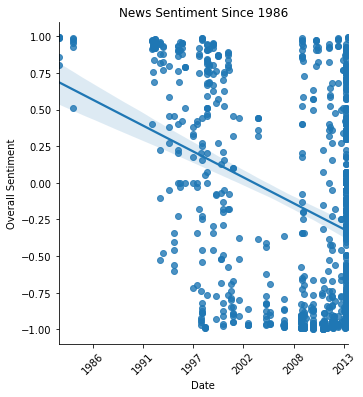

In [13]:
# Overall New Sentiment
g = sns.lmplot(x="date_num", y="compound", data=sent_over_time)

date_form = DateFormatter("%Y")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(date_form)
    ax.set(xlabel="Date", ylabel="Overall Sentiment")
    ax.set_title("News Sentiment Since 1986")
plt.xticks(rotation=45) 

plt.savefig("sent_over_time.png", bbox_inches='tight')

g

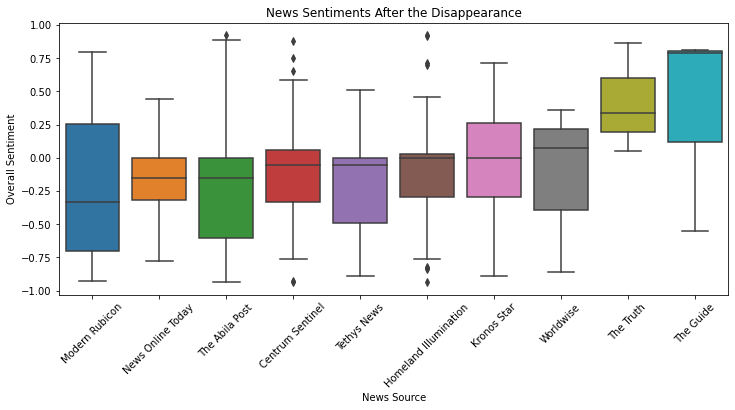

In [14]:
# News Sentiment on day of kidnapping
top_news = sent_over_time\
    .query("source_count > 25")\
    .query("source not in ('Daily Pegasus', 'The Wrap', 'The Orb')") # Removed for having 1 or no post-disappearance articles

sent_order = top_news.query('date >= "2014-01-20"')[["source", "compound"]]\
    .groupby("source").agg("median").reset_index().sort_values("compound").source

plt.figure(figsize=(12,5))
sns.boxplot(x='source', y='compound', 
                data=top_news.query('date >= "2014-01-20"'), order=sent_order)\
    .set_title("News Sentiments After the Disappearance")

plt.xlabel("News Source")
plt.ylabel("Overall Sentiment")
plt.xticks(rotation=45) 
plt.savefig("sent_post_disappearance.png")
plt.show()

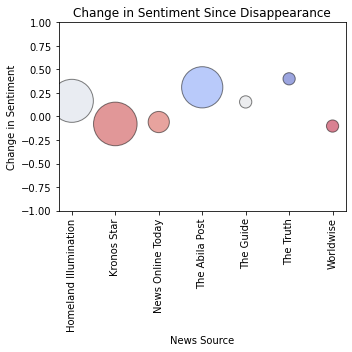

In [15]:
pre_event_sent = top_news.query('date < "2014-01-20"')[["source", "compound"]]\
    .groupby("source").agg(["mean", "count"])\
    .reset_index()
pre_event_sent.columns = ['source', 'pre_mean', 'pre_count']

post_event_sent = top_news.query('date >= "2014-01-20"')[["source", "compound"]]\
    .groupby("source").agg(["mean", "count"])\
    .reset_index()
post_event_sent.columns = ['source', 'post_mean', 'post_count']

#pre_event_sent.merge(post_event_sent, "left")
time_dif_sent = pre_event_sent.merge(post_event_sent, on="source")
time_dif_sent["difference"] = time_dif_sent.apply(lambda row: row["post_mean"] - row["pre_mean"], axis=1)


plt.figure(figsize=(5,5))
sizes = (min(time_dif_sent["post_count"]) * 50, max(time_dif_sent["post_count"])* 50)
g = sns.scatterplot(x="source", y="difference", hue="difference", 
                    size="post_count", alpha=0.5, 
                    linewidth=1, edgecolor="k",
                    palette=sns.color_palette("coolwarm_r", as_cmap=True,),
                    data=time_dif_sent, sizes=sizes)

plt.legend([],[], frameon=False)
g.set(xlabel="News Source", ylabel="Change in Sentiment")
g.set_title("Change in Sentiment Since Disappearance")
g.set(ylim=(-1, 1))
plt.xticks(rotation=90) 
plt.tight_layout()
plt.savefig("sent_change.png")
plt.show()

In [16]:
sent_table = time_dif_sent.sort_values("difference")
sent_table.columns = ["Source", "Pre-Event Sentiment (mean)", "Pre-Event Articles (n)", 
                 "Post-Event Sentiment (mean)", "Post-Event Articles (n)", "Change in Sentiment"]
sent_table

,Source,Pre-Event Sentiment (mean),Pre-Event Articles (n),Post-Event Sentiment (mean),Post-Event Articles (n),Change in Sentiment
6,Worldwise,-0.037516,25,-0.139267,3,-0.101751
1,Kronos Star,0.020904,24,-0.058368,38,-0.079273
2,News Online Today,-0.137801,90,-0.196844,9,-0.059043
4,The Guide,0.196304,25,0.351000,3,0.154696
0,Homeland Illumination,-0.236842,26,-0.070595,37,0.166248
3,The Abila Post,-0.539484,19,-0.229406,34,0.310078
5,The Truth,0.017664,25,0.418033,3,0.400369


## What is being Talked About After the Disappearance?

In [17]:
# TFIDF with classes representing pre/post event time
tfidf = TfidfVectorizer(sublinear_tf=False, min_df=10,
                        ngram_range=(1, 4))

features = tfidf.fit_transform(articles.clean_text).toarray()
labels = articles.post_kidnap


ngram_lens = [1,2,3,4]
features_chi2 = chi2(features, labels == 1)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf.get_feature_names())[indices]
post_dict = {}
for l in ngram_lens:
    grams = [v for v in feature_names if len(v.split(' ')) == l]
    post_dict[l] = grams[-10:]
    
features_chi2 = chi2(features, labels == 0)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf.get_feature_names())[indices]
pre_dict = {}
for l in ngram_lens:
    grams = [v for v in feature_names if len(v.split(' ')) == l]
    pre_dict[l] = grams[-10:]



print(pd.DataFrame(post_dict))
print(pd.DataFrame(pre_dict))

                1                       2                        3  \
0          demand            kronos abila    cio ada campocorrente   
1            safe             federal law  campocorrente coo orhan   
2       yesterday  international employee      ingrid barranco cio   
3  responsibility            elodis rural    ada campocorrente coo   
4             ceo           president ceo   abila kronos protector   
5       disappear             kronos take         sten sanjorge jr   
6            miss                ceo sten      abila kronos police   
7      conference         law enforcement  kronos protector kronos   
8          kidnap   responsibility kidnap        ceo sten sanjorge   
9          ransom        press conference       president ceo sten   

                                4  
0  police spokesman adrien carman  
1     spokesman adrien carman say  
2   campocorrente coo orhan strum  
3       cio ada campocorrente coo  
4  barranco cio ada campocorrente  
5         ing

# Part 4: Employee Networks

## Who is talking to who?
The following two heatmaps shows which employees communicated the most. The first heat map is of the raw data and the second displays communications normalized by each 

<AxesSubplot:>

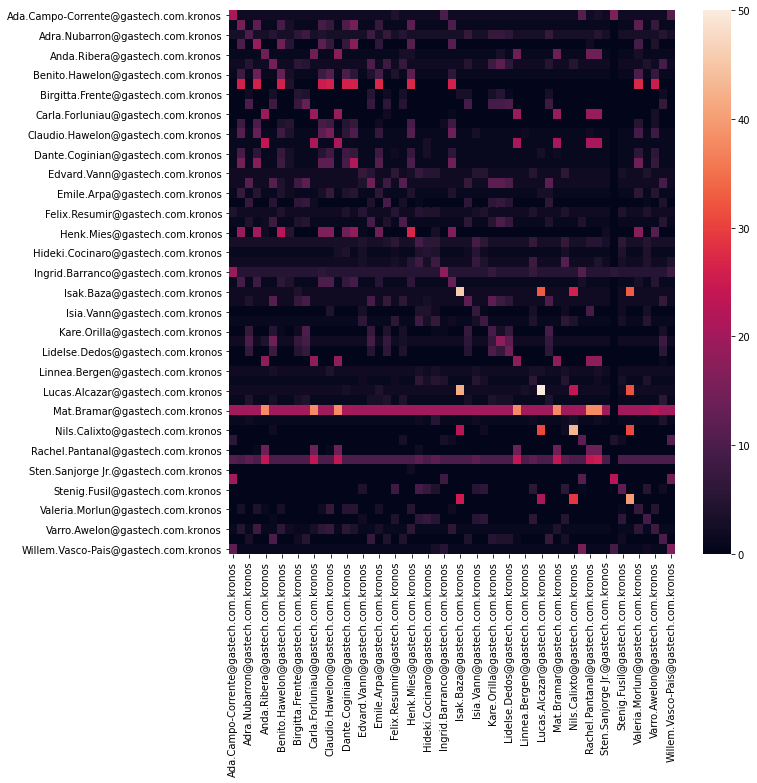

In [18]:
# Raw Communications
plt.figure(figsize=(10,10))
sns.heatmap(emails_connections)

## Criteria for Optimal Network Analysis

In [19]:
# Search historical reports for pok members inside GAStech
report_5yr_np = list(TextBlob(report_5yr).noun_phrases)
report_10yr_np = list(TextBlob(report_10yr).noun_phrases)

# Any employees with relatives (according to last name) in POK articles?
pok_relatives = emp_records[emp_records.LastName.str.lower().isin(report_5yr_np) |\
                            emp_records.LastName.str.lower().isin(report_10yr_np)]
pok_relatives[["name", "BirthDate", "BirthCountry", "Gender", "CurrentEmploymentTitle", "CurrentEmploymentStartDate", "MilitaryServiceBranch"]]

,name,BirthDate,BirthCountry,Gender,CurrentEmploymentTitle,CurrentEmploymentStartDate,MilitaryServiceBranch
32,Henk Mies,1984-09-23,Kronos,Male,Truck Driver,2013-07-12,ArmedForcesOfKronos
46,Minke Mies,1992-11-19,Kronos,Male,Perimeter Control,2013-05-22,ArmedForcesOfKronos
47,Hennie Osvaldo,1988-05-31,Kronos,Male,Perimeter Control,2011-06-07,ArmedForcesOfKronos
48,Isia Vann,1986-12-13,Kronos,Male,Perimeter Control,2007-12-14,ArmedForcesOfKronos
49,Edvard Vann,1991-03-18,Kronos,Male,Perimeter Control,2013-08-15,ArmedForcesOfKronos
51,Loreto Bodrogi,1989-04-17,Kronos,Male,Site Control,2013-08-17,ArmedForcesOfKronos


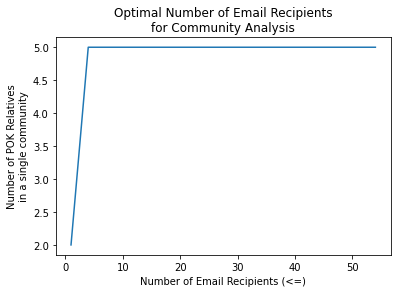

In [20]:
def find_community_inclusion(data, include_names):
    G = nx.from_pandas_edgelist(df=data, source="From", target="To")
    G.add_nodes_from(nodes_for_adding=data.From.tolist())
    
    communities = community.greedy_modularity_communities(G)
    modularity_dict = {} 
    # Add each person and community to the community dictionary
    for i,c in enumerate(communities): 
        for name in c: 
            modularity_dict[name] = i 

    nx.set_node_attributes(G, modularity_dict, 'modularity')

    community_dict = defaultdict()
    # Track communities with more than 2 nodes
    for i,c in enumerate(communities): 
        if len(c) > 2: 
            community_dict['Group '+str(i)] = list(c)
            
    n_included = []
    for g in community_dict:
        n_included.append(sum(pok_relatives.EmailAddress.isin(community_dict[g])))
        
    return(max(n_included))

# Loop through each possible number of recipients to find best filter
pok_relatives_dict = {}
for i in range(1,55):
    dat = paired_emails[paired_emails.recipients <= i]
    max_inc = find_community_inclusion(data = dat, 
                                       include_names=pok_relatives.EmailAddress)
    
    pok_relatives_dict[i] = max_inc
    
# Finding the smallest number of recipients that groups as many POK relatives as possible
n_recipients = np.argmax(list(pok_relatives_dict.values()))


sns.lineplot(x="index", y=0, data=pd.DataFrame([pok_relatives_dict]).T.reset_index())
plt.xlabel('Number of Email Recipients (<=)')
plt.ylabel('Number of POK Relatives\nin a single community')
plt.title('Optimal Number of Email Recipients\nfor Community Analysis')
plt.savefig("email_filter.png")
plt.show()

### Plotting networks
- Full
- Minus company wide emails
- Optimal (Recipients <= 4)

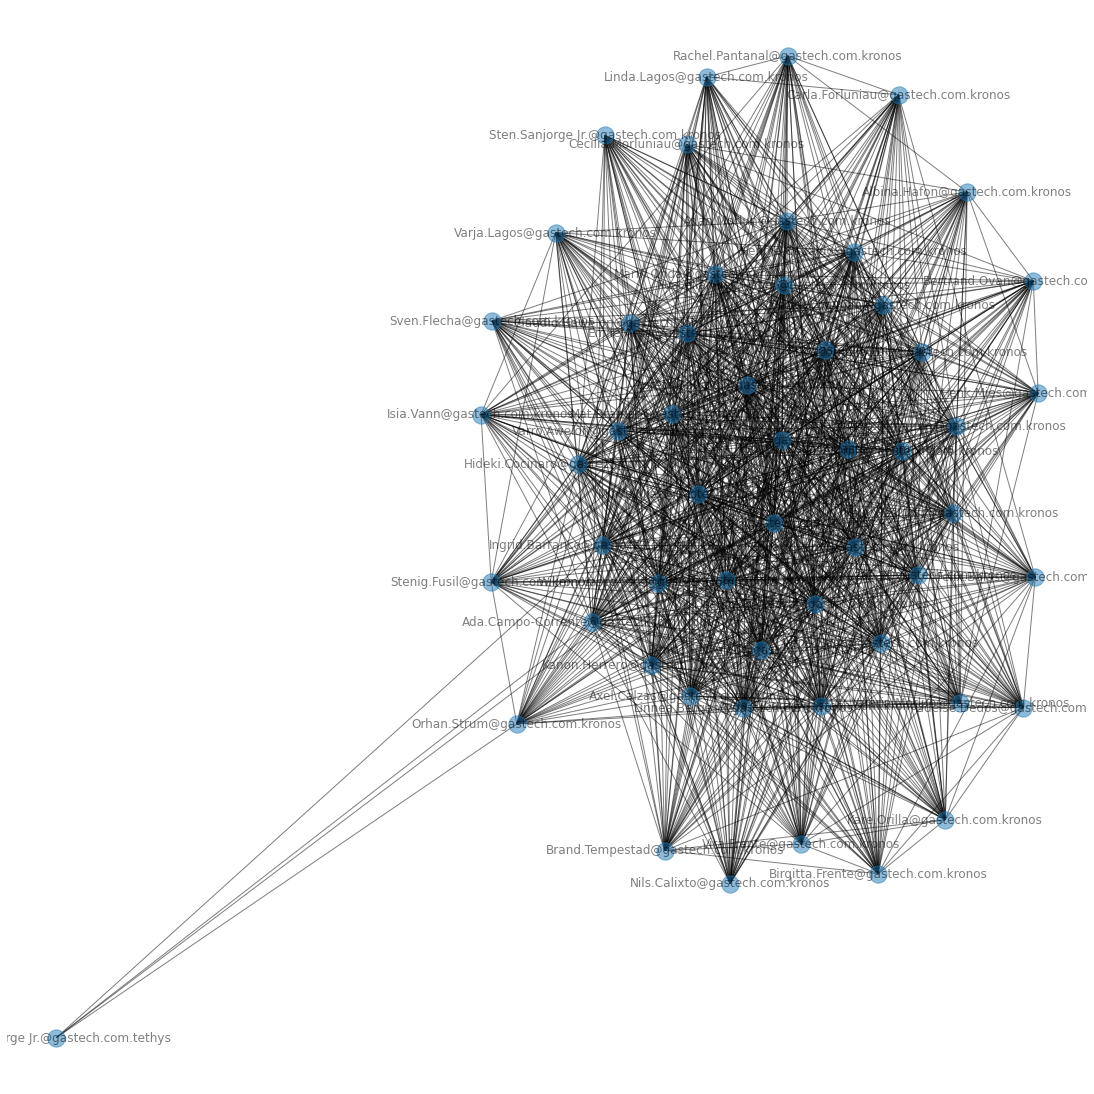

In [21]:
G = nx.from_pandas_edgelist(df=paired_emails, source="From", target="To")
G.add_nodes_from(nodes_for_adding=paired_emails.From.tolist())
plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, alpha=0.5)
plt.savefig("email_network_full.png")

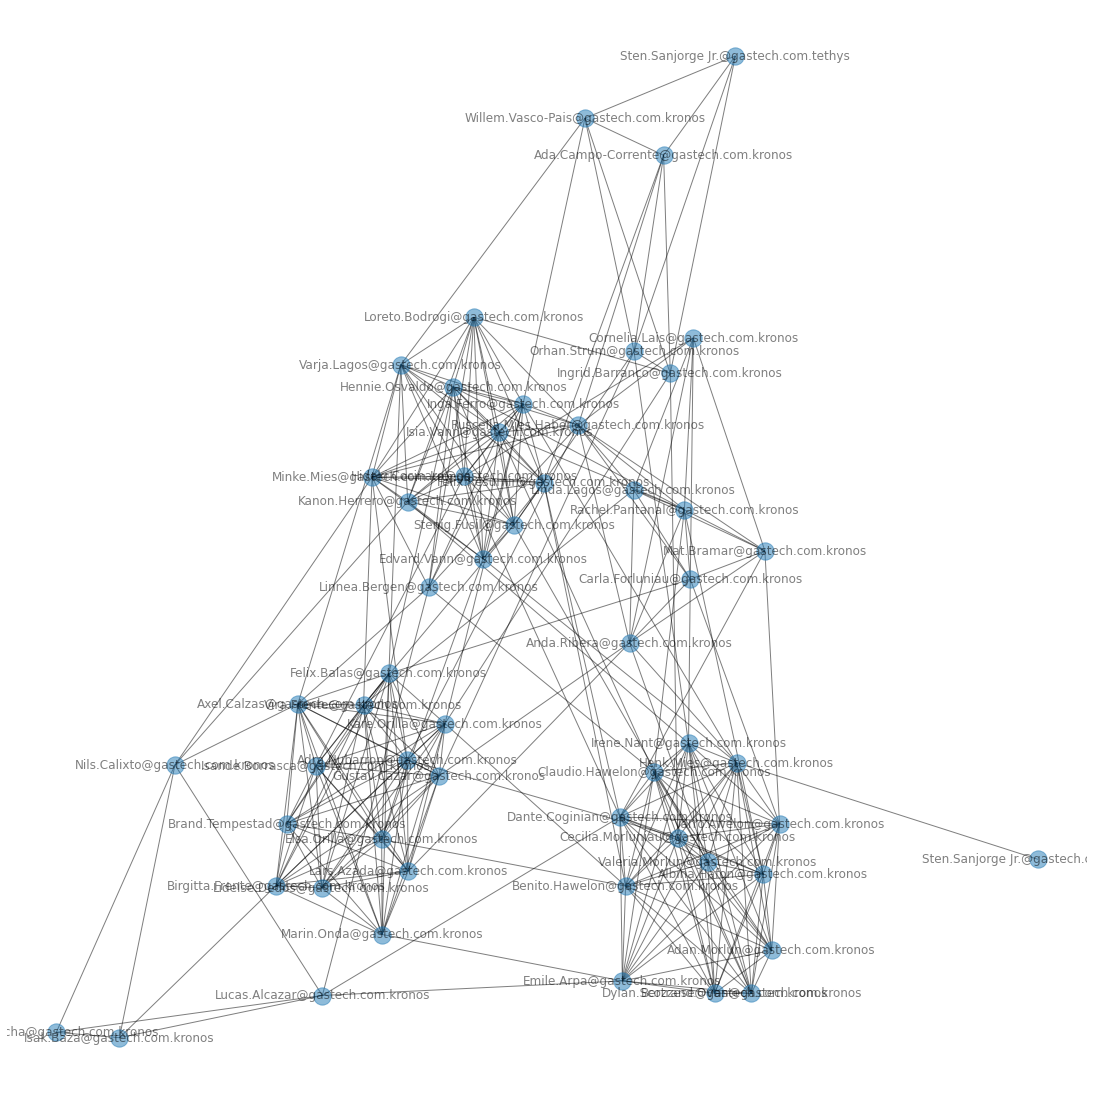

In [22]:
G = nx.from_pandas_edgelist(df=paired_emails.query('recipients < 54'), source="From", target="To")
G.add_nodes_from(nodes_for_adding=paired_emails.From.tolist())
plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, alpha=0.5)
plt.savefig("email_network_54.png")

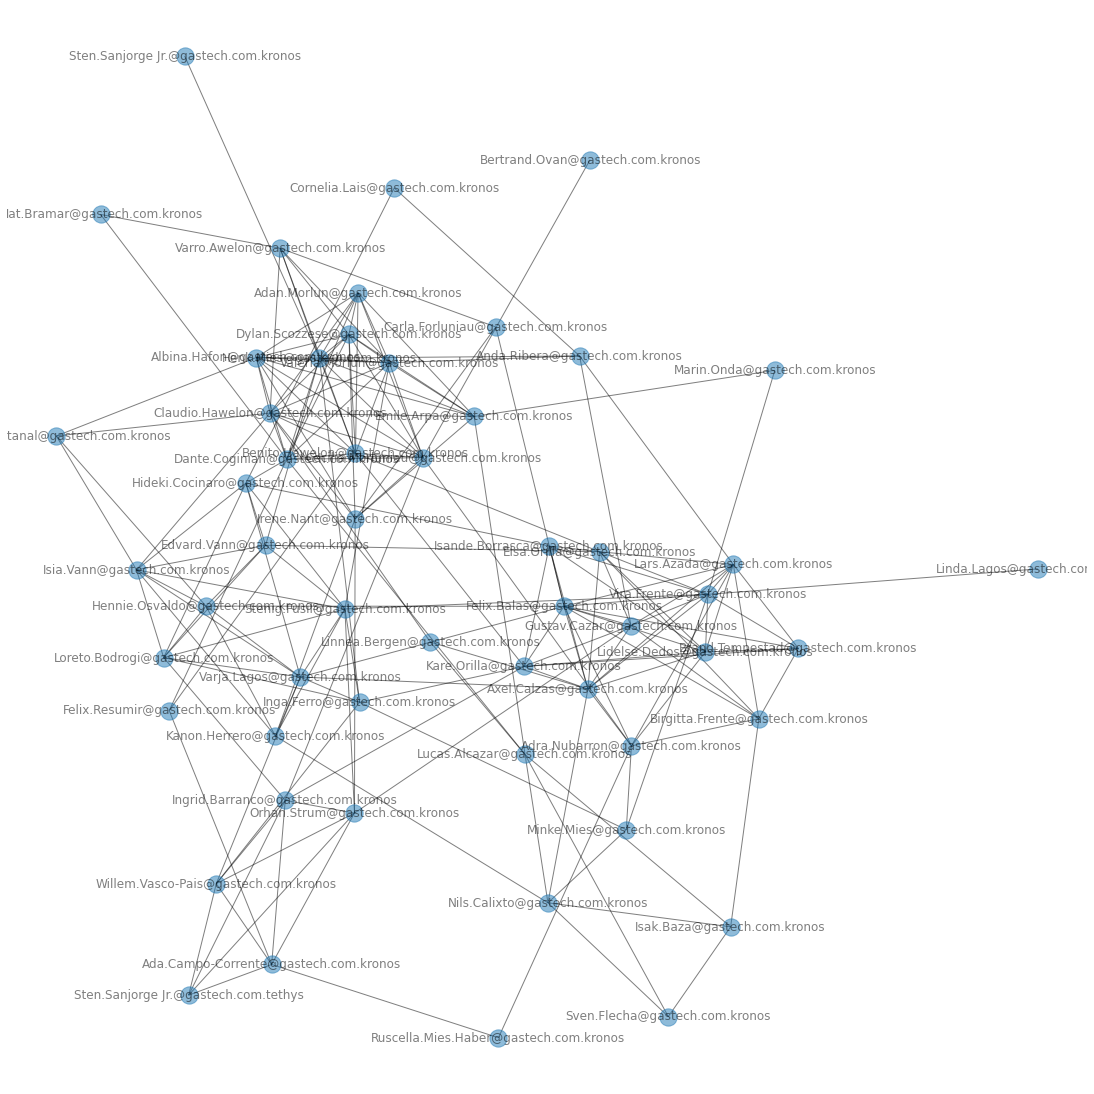

In [23]:
G = nx.from_pandas_edgelist(df=paired_emails.query('recipients <=4'), source="From", target="To")
G.add_nodes_from(nodes_for_adding=paired_emails.From.tolist())
plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, alpha=0.5)
plt.savefig("email_network_4.png")

In [24]:
# Create the same community loop as used before but output it this time for the optimal network
communities = community.greedy_modularity_communities(G)
modularity_dict = {} 
for i,c in enumerate(communities): 
    for name in c:
        modularity_dict[name] = i 

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

community_dict = defaultdict()
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        community_dict['Group '+str(i)] = list(c)
        
max_len = max([len(community_dict[g]) for g in community_dict.keys()])

for g in community_dict.keys():
    g_len = len(community_dict[g])
    if g_len < max_len:
        pad_len = max_len-g_len
        for i in range(pad_len):
            community_dict[g].append(None)
            

community_df = pd.DataFrame([community_dict]).apply(pd.Series.explode)
community_df

,Group 0,Group 1,Group 2,Group 3,Group 4
0,Irene.Nant@gastech.com.kronos,Linda.Lagos@gastech.com.kronos,Loreto.Bodrogi@gastech.com.kronos,Felix.Resumir@gastech.com.kronos,Lucas.Alcazar@gastech.com.kronos
0,Emile.Arpa@gastech.com.kronos,Lars.Azada@gastech.com.kronos,Inga.Ferro@gastech.com.kronos,Willem.Vasco-Pais@gastech.com.kronos,Sven.Flecha@gastech.com.kronos
0,Carla.Forluniau@gastech.com.kronos,Isande.Borrasca@gastech.com.kronos,Varja.Lagos@gastech.com.kronos,Orhan.Strum@gastech.com.kronos,Isak.Baza@gastech.com.kronos
0,Bertrand.Ovan@gastech.com.kronos,Brand.Tempestad@gastech.com.kronos,Hennie.Osvaldo@gastech.com.kronos,Sten.Sanjorge Jr.@gastech.com.tethys,Axel.Calzas@gastech.com.kronos
0,Claudio.Hawelon@gastech.com.kronos,Vira.Frente@gastech.com.kronos,Isia.Vann@gastech.com.kronos,Ada.Campo-Corrente@gastech.com.kronos,Nils.Calixto@gastech.com.kronos
0,Cornelia.Lais@gastech.com.kronos,Birgitta.Frente@gastech.com.kronos,Stenig.Fusil@gastech.com.kronos,Ingrid.Barranco@gastech.com.kronos,Linnea.Bergen@gastech.com.kronos
0,Adan.Morlun@gastech.com.kronos,Adra.Nubarron@gastech.com.kronos,Minke.Mies@gastech.com.kronos,Ruscella.Mies.Haber@gastech.com.kronos,None
0,Marin.Onda@gastech.com.kronos,Kare.Orilla@gastech.com.kronos,Rachel.Pantanal@gastech.com.kronos,None,None
0,Dante.Coginian@gastech.com.kronos,Felix.Balas@gastech.com.kronos,Kanon.Herrero@gastech.com.kronos,None,None
0,Cecilia.Morluniau@gastech.com.kronos,Lidelse.Dedos@gastech.com.kronos,Edvard.Vann@gastech.com.kronos,None,None


In [25]:
# Employee information on all of the POK containing community
pok_group = np.argmax([sum(pok_relatives.EmailAddress.isin(community_dict[g])) for g in community_dict])
pok_group_df = emp_records[emp_records.EmailAddress.isin(community_df["Group "+str(pok_group)].dropna())]
pok_group_df

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,name
2,Pantanal,Rachel,1984-08-22,Tethys,Female,Tethys,BirthNation,1984-08-22,Tethys,2013-06-13,2023-06-12,Administration,Assistant to CIO,2013-10-01,Rachel.Pantanal@gastech.com.kronos,NaN,NaN,NaT,Rachel Pantanal
43,Herrero,Kanon,1984-10-03,Tethys,Male,Tethys,BirthNation,1984-10-03,Tethys,2008-10-10,2018-10-09,Security,Badging Office,2008-11-20,Kanon.Herrero@gastech.com.kronos,NaN,NaN,NaT,Kanon Herrero
44,Lagos,Varja,1976-05-01,Tethys,Female,Tethys,BirthNation,1976-05-01,Tethys,2013-07-07,2023-07-06,Security,Badging Office,2006-10-01,Varja.Lagos@gastech.com.kronos,NaN,NaN,NaT,Varja Lagos
45,Fusil,Stenig,1963-04-29,Tethys,Male,Tethys,BirthNation,1963-04-29,Tethys,2006-04-03,2016-04-02,Security,Building Control,2004-02-05,Stenig.Fusil@gastech.com.kronos,TethanDefenseForceArmy,HonorableDischarge,1987-10-01,Stenig Fusil
46,Mies,Minke,1992-11-19,Kronos,Male,Kronos,BirthNation,1992-11-19,NaN,NaT,NaT,Security,Perimeter Control,2013-05-22,Minke.Mies@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2011-10-01,Minke Mies
47,Osvaldo,Hennie,1988-05-31,Kronos,Male,Kronos,BirthNation,1988-05-31,NaN,NaT,NaT,Security,Perimeter Control,2011-06-07,Hennie.Osvaldo@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2010-10-01,Hennie Osvaldo
48,Vann,Isia,1986-12-13,Kronos,Male,Kronos,BirthNation,1986-12-13,NaN,NaT,NaT,Security,Perimeter Control,2007-12-14,Isia.Vann@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2007-10-01,Isia Vann
49,Vann,Edvard,1991-03-18,Kronos,Male,Kronos,BirthNation,1991-03-18,NaN,NaT,NaT,Security,Perimeter Control,2013-08-15,Edvard.Vann@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,2011-10-01,Edvard Vann
51,Bodrogi,Loreto,1989-04-17,Kronos,Male,Kronos,BirthNation,1989-04-17,NaN,NaT,NaT,Security,Site Control,2013-08-17,Loreto.Bodrogi@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,2008-10-01,Loreto Bodrogi
52,Cocinaro,Hideki,1980-12-25,Tethys,Male,Tethys,BirthNation,1980-12-25,Tethys,2013-05-25,2023-05-24,Security,Site Control,2010-01-01,Hideki.Cocinaro@gastech.com.kronos,TethanDefenseForceArmy,HonorableDischarge,2009-10-01,Hideki Cocinaro


In [26]:
eigenvector_dict = nx.eigenvector_centrality(G) 
pok_centrality = {}
for em in pok_group_df.EmailAddress:
    pok_centrality[em] = eigenvector_dict[em]
    
pok_centrality = pd.DataFrame([pok_centrality]).T.reset_index()
pok_centrality

,index,0
0,Rachel.Pantanal@gastech.com.kronos,0.072096
1,Kanon.Herrero@gastech.com.kronos,0.058461
2,Varja.Lagos@gastech.com.kronos,0.084098
3,Stenig.Fusil@gastech.com.kronos,0.106398
4,Minke.Mies@gastech.com.kronos,0.026031
5,Hennie.Osvaldo@gastech.com.kronos,0.061610
6,Isia.Vann@gastech.com.kronos,0.098169
7,Edvard.Vann@gastech.com.kronos,0.085833
8,Loreto.Bodrogi@gastech.com.kronos,0.069418
9,Hideki.Cocinaro@gastech.com.kronos,0.082556


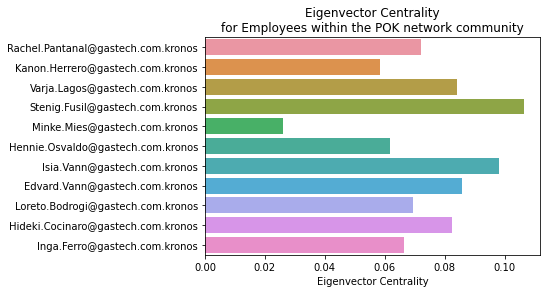

In [27]:
sns.barplot(y="index", x=0, data=pok_centrality)
plt.title("Eigenvector Centrality\nfor Employees within the POK network community")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("")
plt.savefig("pok_network_centrality.png")
plt.show()

In [28]:
between_dict = nx.betweenness_centrality(G) 
pok_betweenness = {}
for em in pok_group_df.EmailAddress:
    pok_betweenness[em] = between_dict[em]
    
pok_betweenness = pd.DataFrame([pok_betweenness]).T.reset_index()
pok_betweenness

,index,0
0,Rachel.Pantanal@gastech.com.kronos,0.004604
1,Kanon.Herrero@gastech.com.kronos,0.023312
2,Varja.Lagos@gastech.com.kronos,0.039915
3,Stenig.Fusil@gastech.com.kronos,0.051234
4,Minke.Mies@gastech.com.kronos,0.012903
5,Hennie.Osvaldo@gastech.com.kronos,0.018619
6,Isia.Vann@gastech.com.kronos,0.021273
7,Edvard.Vann@gastech.com.kronos,0.017355
8,Loreto.Bodrogi@gastech.com.kronos,0.012928
9,Hideki.Cocinaro@gastech.com.kronos,0.040159


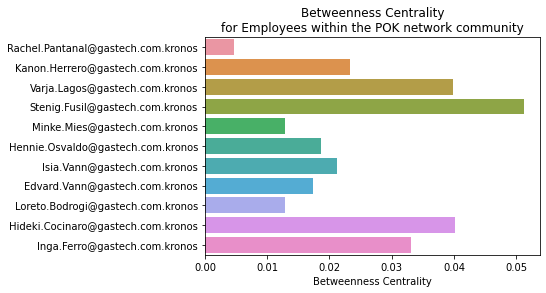

In [29]:
sns.barplot(y="index", x=0, data=pok_betweenness)
plt.title("Betweenness Centrality\nfor Employees within the POK network community")
plt.xlabel("Betweenness Centrality")
plt.ylabel("")
plt.savefig("pok_network_betweenness.png")
plt.show()

# Part 5 - Text Modeling 

In [30]:
# Defining a function that will perform cross validation for oversampling trials
def make_cv_model(x, y, pipeline):
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(x, y):
        lr_fit = pipeline.fit(x[train], y[train])
        prediction = lr_fit.predict(x[test])
        scores = lr_fit.score(x[test],y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(y[test], prediction, average='macro')*100)
        recall.append(recall_score(y[test], prediction, average='macro')*100)
        f1.append(f1_score(y[test], prediction, average='macro')*100)
        
    out_dict = {
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'f1':f1
    }

    return(out_dict)


In [31]:
# Fitting a TFIDF with ngrams to the cleaned text

tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 4))
lr = LogisticRegression()
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=0),lr)
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=0),lr)
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])


tv = TfidfVectorizer(stop_words=None, max_features=100000, min_df=10)
tfidf = tv.fit_transform(articles.clean_text)
ros = RandomOverSampler(random_state=0)
X_ROS, y_ROS = ros.fit_resample(tfidf, articles.post_kidnap)
pd.DataFrame(tfidf.todense(), columns=tv.get_feature_names())


,abila,able,access,accident,accord,account,accusation,accuse,act,action,...,work,worker,world,would,wound,xylene,year,yesterday,yet,young
0,0.037528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.074031,0.000000,0.000000,0.000000,0.000000,0.000000,0.056369,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.213988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200137,0.000000
3,0.044948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135027,0.000000,0.000000,0.000000
4,0.041077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.081032,0.141940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.101480,0.000000,0.137417,0.000000,0.000000,0.000000,0.154539,0.000000,0.000000,0.000000
6,0.102879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.046189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.047958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
ros_results = make_cv_model(articles.clean_text, articles.post_kidnap, ROS_pipeline)
original_results = make_cv_model(articles.clean_text, articles.post_kidnap, original_pipeline)
smote_results = make_cv_model(articles.clean_text, articles.post_kidnap, SMOTE_pipeline)


/home/travis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/travis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/travis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/travis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification

In [33]:
print("No Oversampling")
pd.DataFrame(original_results)

No Oversampling


,accuracy,precision,recall,f1
0,94.08284,47.04142,50.0,48.47561
1,94.08284,47.04142,50.0,48.47561
2,94.08284,47.04142,50.0,48.47561
3,94.08284,47.04142,50.0,48.47561
4,94.08284,47.04142,50.0,48.47561


In [34]:
print("Random Oversampling")
pd.DataFrame(ros_results)

Random Oversampling


,accuracy,precision,recall,f1
0,97.041420,91.622575,79.685535,84.515301
1,97.633136,92.818323,84.685535,88.263889
2,98.816568,99.378882,90.000000,94.131944
3,97.633136,98.773006,80.000000,86.878882
4,97.633136,92.818323,84.685535,88.263889


In [35]:
print("SMOTE")
pd.DataFrame(smote_results)

SMOTE


,accuracy,precision,recall,f1
0,97.041420,91.622575,79.685535,84.515301
1,98.224852,99.074074,85.000000,90.709181
2,98.224852,99.074074,85.000000,90.709181
3,97.633136,98.773006,80.000000,86.878882
4,97.633136,92.818323,84.685535,88.263889


In [36]:
# Checking feature importance and setting colors / ngram length parameters for graphing
lr_fit = ROS_pipeline.fit(articles.clean_text, articles.post_kidnap)
feature_names = lr_fit.named_steps["tfidfvectorizer"].get_feature_names()
coefs = lr_fit.named_steps["logisticregression"].coef_.flatten()

zipped = zip(feature_names, coefs)
lr_feature_importance = pd.DataFrame(zipped, columns=["feature", "value"])# Sort the features by the absolute value of their coefficient
lr_feature_importance["abs_value"] = lr_feature_importance["value"].apply(lambda x: abs(x))
lr_feature_importance["colors"] = lr_feature_importance["value"].apply(lambda x: "red" if x > 0 else "green")
lr_feature_importance["ngram_len"] = lr_feature_importance["feature"].apply(lambda x: len(x.split(" ")))
lr_feature_importance = lr_feature_importance.sort_values("abs_value", ascending=False)

lr_feature_importance

,feature,value,abs_value,colors,ngram_len
92055,update,3.194345,3.194345,red,1
44875,modernization,2.968112,2.968112,red,1
40890,kidnap,2.199899,2.199899,red,1
44551,miss,1.943546,1.943546,red,1
16909,conference,1.848813,1.848813,red,1
...,...,...,...,...,...
1374,access,-0.001120,0.001120,green,1
82182,strict,-0.000873,0.000873,green,1
12815,cfo ingrid barranco cio,0.000757,0.000757,red,4
15557,company,0.000739,0.000739,red,1


<ipython-input-54-173247b3a0ec>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0, 0.5, 'Feature Name')

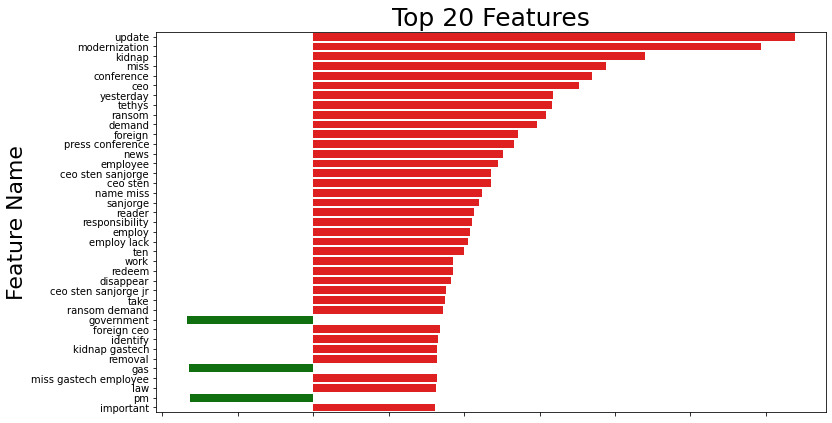

In [54]:
# Overall ngram plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(y="feature",
            x="value",
            data=lr_feature_importance[lr_feature_importance.abs_value > .8],
           palette=lr_feature_importance[lr_feature_importance.abs_value > .8]["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_xlabel("Coefficient Value", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22)

In [55]:
# Defining a function that will plot by ngram length
def plot_feature_grams(ngram_length, title):
    tmp = lr_feature_importance[lr_feature_importance.ngram_len == ngram_length]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(y="feature",
                x="value",
                data=tmp.head(20),
               palette=tmp.head(20)["colors"])
    ax.set_title(title, fontsize=25)
    ax.set_xlabel("Coefficient Value", fontsize=22)
    ax.set_ylabel("Feature Name", fontsize=22)    


#### Feature importance plots by ngram length

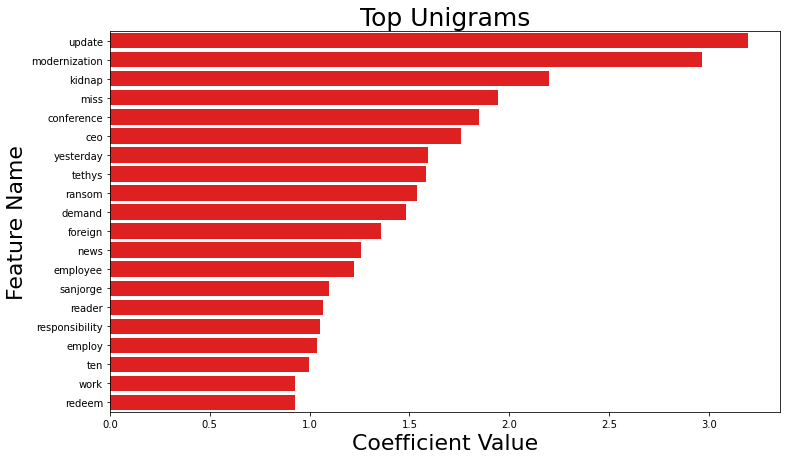

In [56]:
plot_feature_grams(1, title = "Top Unigrams")
plt.savefig("Top Unigrams.png")

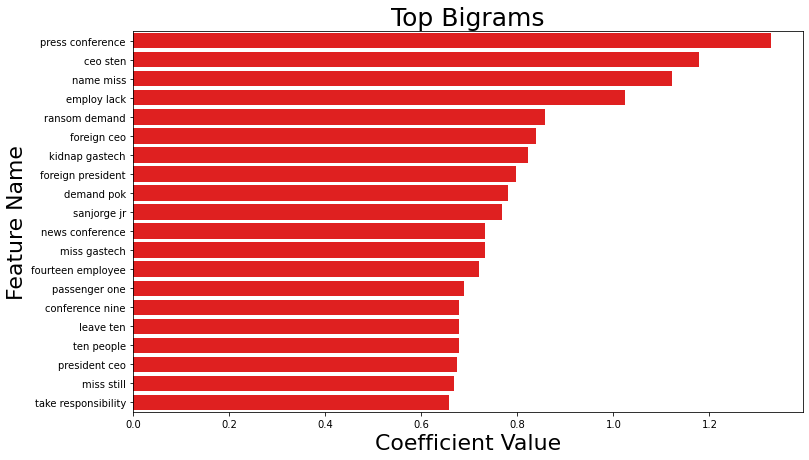

In [57]:
plot_feature_grams(2, title="Top Bigrams")
plt.savefig("Top Bigrams.png")

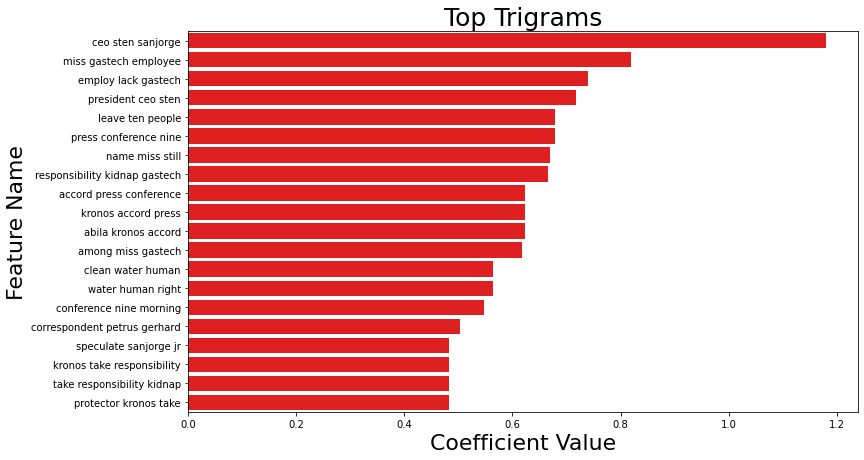

In [58]:
plot_feature_grams(3, title = "Top Trigrams")
plt.savefig("Top Trigrams.png")

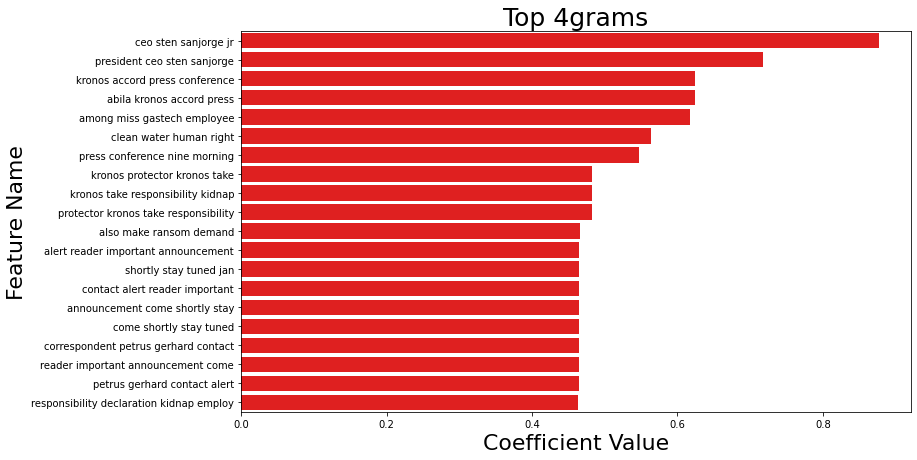

In [59]:
plot_feature_grams(4, title = "Top 4grams")
plt.savefig("Top 4grams.png")

### RAKE

In [43]:
# RAKE was done on non-cleaned text. The lemmatization, lower casing, and punctuation removal inhibited the algorithm.

post_kidnap_text = articles.text[articles.post_kidnap == 1]
jan20_text = articles.query('date == "2014-01-20"').text
jan21_text = articles.query('date == "2014-01-21"').text


post_kidnap_semi_clean = " ".join([" ".join(list(filter(lambda string: string not in ['', ' '], \
             re.sub('[^a-zA-Z +\\.]', '', x).lower().split(" ")))) \
 for x in post_kidnap_text])

jan20_semi_clean = " ".join([" ".join(list(filter(lambda string: string not in ['', ' '], \
             re.sub('[^a-zA-Z +\\.]', '', x).lower().split(" ")))) \
 for x in jan20_text])

jan21_semi_clean = " ".join([" ".join(list(filter(lambda string: string not in ['', ' '], \
             re.sub('[^a-zA-Z +\\.]', '', x).lower().split(" ")))) \
 for x in jan21_text])


def rake_summary(text):
    r = Rake()
    r.extract_keywords_from_text(text)
    return(r.get_ranked_phrases()[0:20])




In [44]:
post_rake = rake_summary(post_kidnap_semi_clean)
jan20_rake = rake_summary(jan20_semi_clean)
jan21_rake = rake_summary(jan21_semi_clean)

In [45]:
post_rake

['ceo sten sanjorge jr cfo ingrid barranco cio ada campocorrente coo orhan strum',
 'ceo sten sanjorge jrcfo ingrid barranco cio ada campocorrente coo orhan strum',
 'one fears fourteen employees probably including five executive leaders removed yesterday',
 'president sten sanjorge jr cfo ingrid barranco campocorrente',
 'ceo sten sanjorge jr cfo ingrid precipice fieldcorrente',
 'police spokesman adrien carman said tethyn federal law enforcement agencies',
 'tethys likely gastech corporate officials arrived late last night',
 'fourteen employees including possibly five executive officers',
 'cio roucoulement orhan de gastech pianotent',
 'jan breaking news homeland illumination correspondent petrus gerhard',
 'environment civil servant willem vascopais van gastech',
 'executive civil servants perhaps five feared',
 'fourteen gastech employees disappeared sometime yesterday morning',
 'gastech de sten sanjorge returned surely',
 'cancelled tonight although many international dignitari

In [46]:
jan20_rake

['december gastech internationals recent initial public offering ipo netted sten sanjorge jr',
 'update pm abila police spokesman adrien carman said several gastech employees appear',
 'jan homeland illumination correspondent petrus gerhard reports airport officials',
 'jan breaking news homeland illumination correspondent petrus gerhard',
 'security willem vascopais deserved millions also .. although',
 'unaccounted zowat gastech employees still one cannot accuse',
 'update pm abila fire captain federigo accardi announces',
 'roughly speaking urengastech kronos employee edvard vann',
 'abila posts sara tuno reported gastech leadership',
 'homeland illumination correspondent petrus gerhard reports',
 'gastech ipo produced net sten sanjorge jr',
 'roughly hours employed edvard vann de gastech',
 'environmental security willem basouecountry also gained million',
 'december reported internationally recent initially public gastech',
 'environmental safety advisor willem vascopais also earn

In [47]:
jan21_rake

['ceo sten sanjorge jr cfo ingrid barranco cio ada campocorrente coo orhan strum',
 'ceo sten sanjorge jrcfo ingrid barranco cio ada campocorrente coo orhan strum',
 'one fears fourteen employees probably including five executive leaders removed yesterday',
 'president sten sanjorge jr cfo ingrid barranco campocorrente',
 'ceo sten sanjorge jr cfo ingrid precipice fieldcorrente',
 'police spokesman adrien carman said tethyn federal law enforcement agencies',
 'tethys likely gastech corporate officials arrived late last night',
 'fourteen employees including possibly five executive officers',
 'cio roucoulement orhan de gastech pianotent',
 'jan breaking news homeland illumination correspondent petrus gerhard',
 'environment civil servant willem vascopais van gastech',
 'executive civil servants perhaps five feared',
 'fourteen gastech employees disappeared sometime yesterday morning',
 'gastech de sten sanjorge returned surely',
 'fear fourteen employees including possibly',
 'reported

### Text Summarization

In [48]:
print(summarize(post_kidnap_semi_clean, word_count=100, split=False))

abila kronos the guards of kronos have not only also the taken responsibility for the removal of international employees gastech but the ransom question of m of the president and ceo sten sanjorge jr.
update abila kronos the protectors of kronos have not only taken responsibility for the kidnapping of gastech international employees but have also made a ransom demand of m from the president and ceo sten sanjorge jr.
modernization abila kronos the protectors of kronos have not only taken responsibility for the kidnapping of gastech international employees but have also made a ransom demand of m from the president and ceo sten sanjorge jr.


In [49]:
print(summarize(jan20_semi_clean, word_count=100, split=False))

the abila police know this channel is monitored by the media and often do not give the reason for the response update a kronos government official who asked not to be identified but was present at the government reception has gone on the record stating investigators are working around the clock to ensure that the kidnapped gastech employees are found and that the perpetrators are brought to justice.
abila kronos after a long day of conflicting and confusing information reports are still sketchy but the story is beginning to come clear a kronos government source has confirmed up to fourteen of gastech internationals employees may have been kidnapped at the companys headquarters in abila.


In [50]:
print(summarize(jan21_semi_clean, word_count=100, split=False))

update abila kronos the protectors of kronos have not only taken responsibility for the kidnapping of gastech international employees but have also made a ransom demand of m from the president and ceo sten sanjorge jr.
modernization abila kronos the protectors of kronos have not only taken responsibility for the kidnapping of gastech international employees but have also made a ransom demand of m from the president and ceo sten sanjorge jr.
abila kronos the protectors of kronos have not only taken responsibility for the kidnapping of gastech international employees but have also made a ransom demand of m from the president and ceo sten sanjorge jr.
